# Prédiction des émissions en CO2

#### Contexte :

A partir de relevés déjà effectué par les agents de la ville de Seattle, nous allons tenter de prédire les émissions de CO2 des bâtiments non résidentiels. 

Nous travaillons sur les données, récupérées depuis le site de Seattle, dont le nettoyage et prétraitement a été réalisé dans le premier notebook.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings



In [2]:
data = pd.read_csv("final_data_2.csv", sep = ",")

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698 entries, 0 to 4697
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              4698 non-null   int64  
 1   BuildingType               4698 non-null   object 
 2   PrimaryPropertyType        4698 non-null   object 
 3   CouncilDistrictCode        4698 non-null   float64
 4   Neighborhood               4698 non-null   object 
 5   Latitude                   4698 non-null   float64
 6   Longitude                  4698 non-null   float64
 7   NumberofBuildings          4698 non-null   float64
 8   NumberofFloors             4698 non-null   float64
 9   PropertyGFATotal           4698 non-null   int64  
 10  PropertyGFAParking         4698 non-null   float64
 11  PropertyGFABuilding(s)     4698 non-null   float64
 12  LargestPropertyUseType     4698 non-null   object 
 13  LargestPropertyUseTypeGFA  4698 non-null   float

#### ENERGYSTRARScore : 
on va isoler cette variable pour évaluer sa perfomance par la suite

In [4]:
energy_star_score = data['ENERGYSTARScore']
data = data.drop(columns= 'ENERGYSTARScore')
data.shape

(4698, 20)

Nous allons également supprimer les colonnes :

    - TotalGHGEmissions (variable cible du prochain notebook)
    - OSEBuildingID (variable d'identification que nous n'allons pas utiliser dans la prédiction)

In [5]:
data = data.drop(columns=['SiteEnergyUse(kBtu)', 'OSEBuildingID'])
data.shape


(4698, 18)

Redéfinir les types des variables catégorielles :

In [6]:
categorical_var=["BuildingType", "PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType", "CouncilDistrictCode"]
data[categorical_var] = data[categorical_var].astype('category')

In [7]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698 entries, 0 to 4697
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   BuildingType               4698 non-null   category
 1   PrimaryPropertyType        4698 non-null   category
 2   CouncilDistrictCode        4698 non-null   category
 3   Neighborhood               4698 non-null   category
 4   Latitude                   4698 non-null   float64 
 5   Longitude                  4698 non-null   float64 
 6   NumberofBuildings          4698 non-null   float64 
 7   NumberofFloors             4698 non-null   float64 
 8   PropertyGFATotal           4698 non-null   int64   
 9   PropertyGFAParking         4698 non-null   float64 
 10  PropertyGFABuilding(s)     4698 non-null   float64 
 11  LargestPropertyUseType     4698 non-null   category
 12  LargestPropertyUseTypeGFA  4698 non-null   float64 
 13  TotalGHGEmissions          4698 n

In [8]:
data = data.reindex(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'Neighborhood', 'CouncilDistrictCode', 'BuildingAge',
                     'Latitude', 'Longitude', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
                     'LargestPropertyUseTypeGFA','PropertyGFAParking', 'Building_Rate', 'Largest_Use_Rate', 'Parking_Rate', 
                     'TotalGHGEmissions'], axis=1) 

In [9]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
       'Neighborhood', 'CouncilDistrictCode', 'BuildingAge', 'Latitude',
       'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'PropertyGFAParking', 'Building_Rate', 'Largest_Use_Rate',
       'Parking_Rate', 'TotalGHGEmissions'],
      dtype='object')

## Sommaire :

### 1. Prétraitement : 

- Encodage : TargetEncoder en utlisant la varible cible: SiteEnergyUse(kBtu)
- Transformation log de la variable cible
- Selection de features : méthode RFECV (basée sur différents modèles)
- Split train - test
### 2. Validation croisée :
- standardisation (RobustScaler)
- Prédiction (test avec différents modèle)

### 3. Modèles prédiction et RFECV : 

- Modèle linéaire :
     - LinearRegression
     - RidgeCv
     - LassoCv
     - ElasticNetCv
  
- Modèles non linéaires
  
    - KernelRidge
    - SVR
      
- Méthodes ensemblistes
  
    - Random Forest Regressor
    - XGBoost 
  
### 4. Evaluation des performances : validation croisée et test

    - R2
    - RMSE
    - MAE (mean absolute error)
    - Median absolute error
    - Temps d'entrainement
    - Temps de prédiction
    - Comparaison des distribution vraie valeur et prédiction

In [10]:
# Libraries 

import category_encoders
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.feature_selection import RFECV
from sklearn.kernel_ridge import KernelRidge
import time
import math

In [11]:
# Fonctions 

# Fonction transformation log de la variable cible
def target_transformation(value):
    return np.log(value)

# Fonction encodage :
def encodage(X_train, X_test, y_train):
    encoder = category_encoders.TargetEncoder()
    encoded_features = []
    
    for feature in X_train.columns:
        if X_train[feature].dtype.name == 'category':
            encoder.fit(X_train[feature], y_train)
            
            # Appliquez l'encodage à la fois sur X_train et X_test
            X_train[f'{feature}_encoded'] = encoder.transform(X_train[feature])
            X_test[f'{feature}_encoded'] = encoder.transform(X_test[feature])
            encoded_features.append(f'{feature}_encoded')
    
    return X_train[encoded_features], X_test[encoded_features]


In [48]:
# fonction pretraitement

def preprocessing(data, target, rfe_model):
    # Séparation features et cible
    target = target
    X = data.drop([target], axis=1)
    y = data[target]

    # Transformation de la variable cible
    y_log = y.apply(target_transformation)
    
    # Séparer les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
    
    # Séparation des variable numériques et catégorielles pour l'encodage
    train_categorical_features = X_train.select_dtypes(include='category')
    test_categorical_features = X_test.select_dtypes(include='category')
    
    train_numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
    test_numerical_features = X_test.select_dtypes(include=['int64', 'float64'])
    

    
    # Encodage des variables catégorielles
    train_categorical_features, test_categorical_features = encodage(train_categorical_features, test_categorical_features, y_train)
    
    # Fusion des variables catégorielles et numériques
    X_train = pd.merge(train_categorical_features, train_numerical_features, left_index=True, right_index=True)
    X_test = pd.merge(test_categorical_features, test_numerical_features,  left_index=True, right_index=True)

    
    # Sélection de features avec RFECV
    
    sv = RFECV(rfe_model, step=1, cv=5)
    sv.fit(X_train, y_train)
    selected_columns = [col for col, selected in zip(X_train.columns, sv.support_) if selected]
    X_train = X_train[selected_columns]
    X_test = sv.transform(X_test)
    
    # Accédez aux classements des fonctionnalités
    feature_ranking = sv.ranking_
    # Accédez aux fonctionnalités sélectionnées (True signifie sélectionné)
    selected_features = sv.support_
    
    feature_info = pd.DataFrame({
        'Feature': X.columns, 
        'Ranking': feature_ranking,
        'Selected': selected_features
    })
    print("Données d'entraînement : ", X_train.shape)
    print("Données de test : ", X_test.shape)
    print("Features Sélectionnées par la RFECV :")
    display(feature_info)
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = preprocessing(data, 'TotalGHGEmissions', LinearRegression())

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,4,False
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


## I - Modèles linéaires :

- Test régression linéaire, variable cible transformée en log
- Comparaison regression linéaire variables cible transformée en log et variable cible non transformée

In [43]:
def evaluate_model(data, target, rfe_model, prediction_model):   
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = preprocessing(data, target, rfe_model)
    scaler = RobustScaler()
    
    # Le pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', prediction_model)  
    ])
    
    # Ajuster le pipeline avec les données d'entraînement
    
    # Temps d'entraînement données log
    start_train = time.time()
    pipeline.fit(X_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train
    
    # training score données log
    
    train_rmse = math.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
    train_mae = mean_absolute_error(y_train, pipeline.predict(X_train))
    train_r2 = r2_score(y_train, pipeline.predict(X_train))
    train_med_abs_err = median_absolute_error(y_train, pipeline.predict(X_train))
    
    # Temps de prédiction données log
    start_pred = time.time()
    y_pred = pipeline.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    
    # Mesures des performances - cible
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_err = median_absolute_error(y_test, y_pred)

    y_test_trans = np.exp(y_test)
    y_pred_trans = np.exp(y_pred)
    mae_trans = mean_absolute_error(y_test_trans, y_pred_trans)
    r2_trans = r2_score(y_test_trans, y_pred_trans)
    rmse_trans = np.sqrt(mean_squared_error(y_test_trans, y_pred_trans))
    med_abs_err_trans = median_absolute_error(y_test_trans, y_pred_trans)

    print("Modèle : ", prediction_model)
    print("Scores avec la cible transformée en log puis exp")
    
    score_info = {"Training scores": [train_rmse, train_mae, train_r2, train_med_abs_err, training_time],
                  "Test scores log": [rmse, mae, r2, med_abs_err, prediction_time],
                  "Test scores": [rmse_trans, mae_trans, r2_trans, med_abs_err_trans, prediction_time]
                 }
    df_score_info = pd.DataFrame(score_info,
                          index = ['RMSE', 'MAE', 'R2', 'Median Abs Err', 'Time'])
    
    display(df_score_info)
    
    # ---------------------------------------------------------------------------------
    
    # Données non transformées (log_exp) 
    
    # Temps d'entraînement données log_exp
    y_train_exp = np.exp(y_train)
    y_test_exp = np.exp(y_test)
    
    start_train_exp = time.time()
    pipeline.fit(X_train, y_train_exp)
    end_train_exp = time.time()
    training_time_exp = end_train_exp - start_train_exp
    
    # training score données log_exp
    train_rmse_exp = math.sqrt(mean_squared_error(y_train_exp, pipeline.predict(X_train)))
    train_mae_exp = mean_absolute_error(y_train_exp, pipeline.predict(X_train))
    train_r2_exp = r2_score(y_train_exp, pipeline.predict(X_train))
    train_med_abs_err_exp = median_absolute_error(y_train_exp, pipeline.predict(X_train))
    train_relative_rmse = (train_rmse_exp/(y_train_exp.max() - y_train_exp.min()))*100
    
    # Temps de prédiction données log_exp
    start_pred_exp = time.time()
    y_pred_exp = pipeline.predict(X_test)
    end_pred_exp = time.time()
    prediction_time_exp = end_pred_exp - start_pred_exp
    
    # Mesures des performances - cible log_exp
    mae_exp = mean_absolute_error(y_test_exp, y_pred_exp)
    r2_exp = r2_score(y_test_exp, y_pred_exp)
    rmse_exp = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    med_abs_err_exp = median_absolute_error(y_test_exp, y_pred_exp)
    relative_rmse_exp = (rmse_exp/(y_test_exp.max()-y_test_exp.min()))*100
    
    print("Scores avec cible non transformée")
    score_info_2 = {"Training scores": [train_r2_exp, train_rmse_exp, train_relative_rmse, train_mae_exp, train_med_abs_err_exp, training_time_exp],
                  "Test scores": [r2_exp, rmse_exp, relative_rmse_exp, mae_exp, med_abs_err_exp, prediction_time_exp]
                 }
    df_score_info_2 = pd.DataFrame(score_info_2,
                          index = ['R2', 'RMSE', 'Relative RMSE', 'MAE', 'Median Abs Err', 'Time'])
    
    display(df_score_info_2)

    # Graphique données log
    
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16,12))
    sns.distplot(y_test, ax = axes[0,0], label='Valeur log' )
    sns.distplot(y_pred, ax = axes[0,0], label='Prédiction')
    axes[0,0].set_title('Comparaison des distributions ')
    axes[0,0].legend()
    
    axes[0,1].scatter(y_test, y_pred, alpha=0.5)
    axes[0,1].plot([0, 12],[0, 12], color = 'red', linestyle = '-', linewidth = 1.5)
    axes[0,1].set_xlabel("Valeur log")
    axes[0,1].set_ylabel("Prédiction")
    axes[0,1].set_title("Scatter Plot de valeurs log vs. prédictions")
    
    # Graphique données log_exp
    sns.distplot(y_test_exp, ax = axes[1,0], label='vraie Valeur' )
    sns.distplot(y_pred_exp, ax = axes[1,0], label='Prédiction')
    axes[1,0].set_title('Comparaison des distributions ')
    axes[1,0].legend()
    
    axes[1,1].scatter(y_test_exp, y_pred_exp, alpha=0.5)
    axes[1,1].plot([0, 9e3],[0, 9e3], color = 'red', linestyle = '-', linewidth = 1.5)
    axes[1,1].set_xlabel("Vraie valeur")
    axes[1,1].set_ylabel("Prédiction")
    axes[1,1].set_title("Scatter Plot de Vraie valeurs vs. prédictions")
    plt.show()
    
    return df_score_info_2


### Modèle : LinearRegression
#### LinearRegression : pour la selection de features RFECV

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle :  LinearRegression()
Scores avec la cible transformée en log puis exp


,Training scores,Test scores log,Test scores
RMSE,1.271042,1.229806,3806.036983
MAE,0.994573,0.969119,235.809898
R2,0.280296,0.263789,-54.647656
Median Abs Err,0.819860,0.823607,33.414624
Time,0.015096,0.005614,0.005614


Scores avec cible non transformée


,Training scores,Test scores
R2,0.227498,0.386957
RMSE,694.802975,399.479879
Relative RMSE,3.045705,3.586156
MAE,209.837289,183.602202
Median Abs Err,103.443136,104.812591
Time,0.034088,0.000947


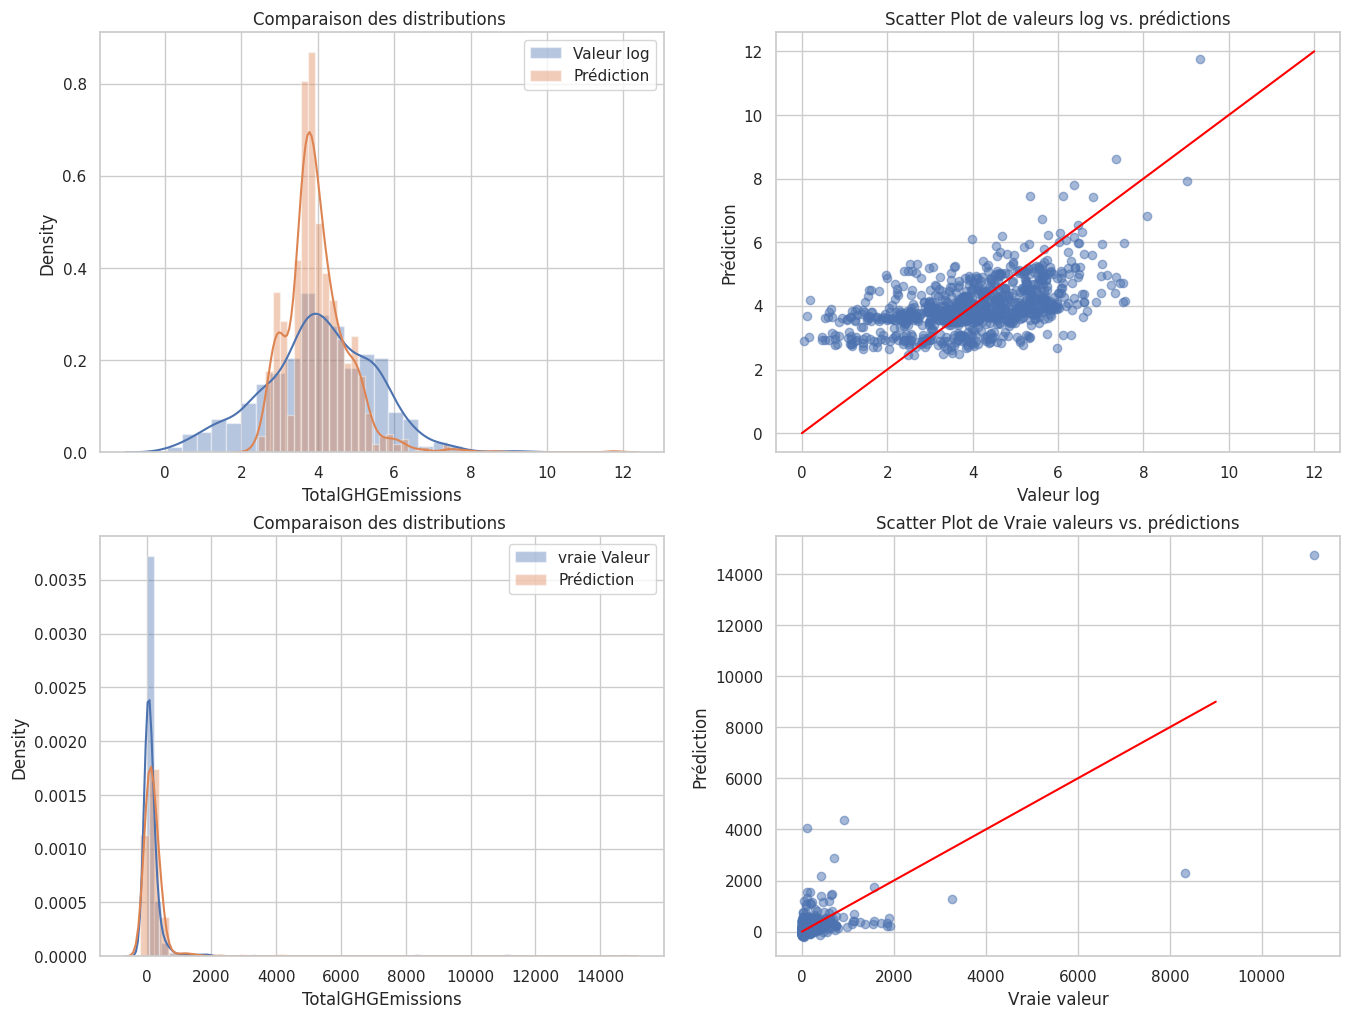

In [49]:
lr_score = evaluate_model(data, 'TotalGHGEmissions', LinearRegression(), LinearRegression())

### Modèle : RidgeCV 
#### LinearRegression : pour la selection de features RFECV

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle :  RidgeCV()
Scores avec la cible transformée en log puis exp


,Training scores,Test scores log,Test scores
RMSE,1.271087,1.229851,3581.433702
MAE,0.994606,0.969206,228.214732
R2,0.280245,0.263735,-48.273647
Median Abs Err,0.821219,0.824774,33.641570
Time,0.056070,0.000514,0.000514


Scores avec cible non transformée


,Training scores,Test scores
R2,0.227432,0.390059
RMSE,694.832388,398.468114
Relative RMSE,3.045834,3.577074
MAE,209.181964,182.929682
Median Abs Err,103.866782,105.117241
Time,0.080240,0.006484


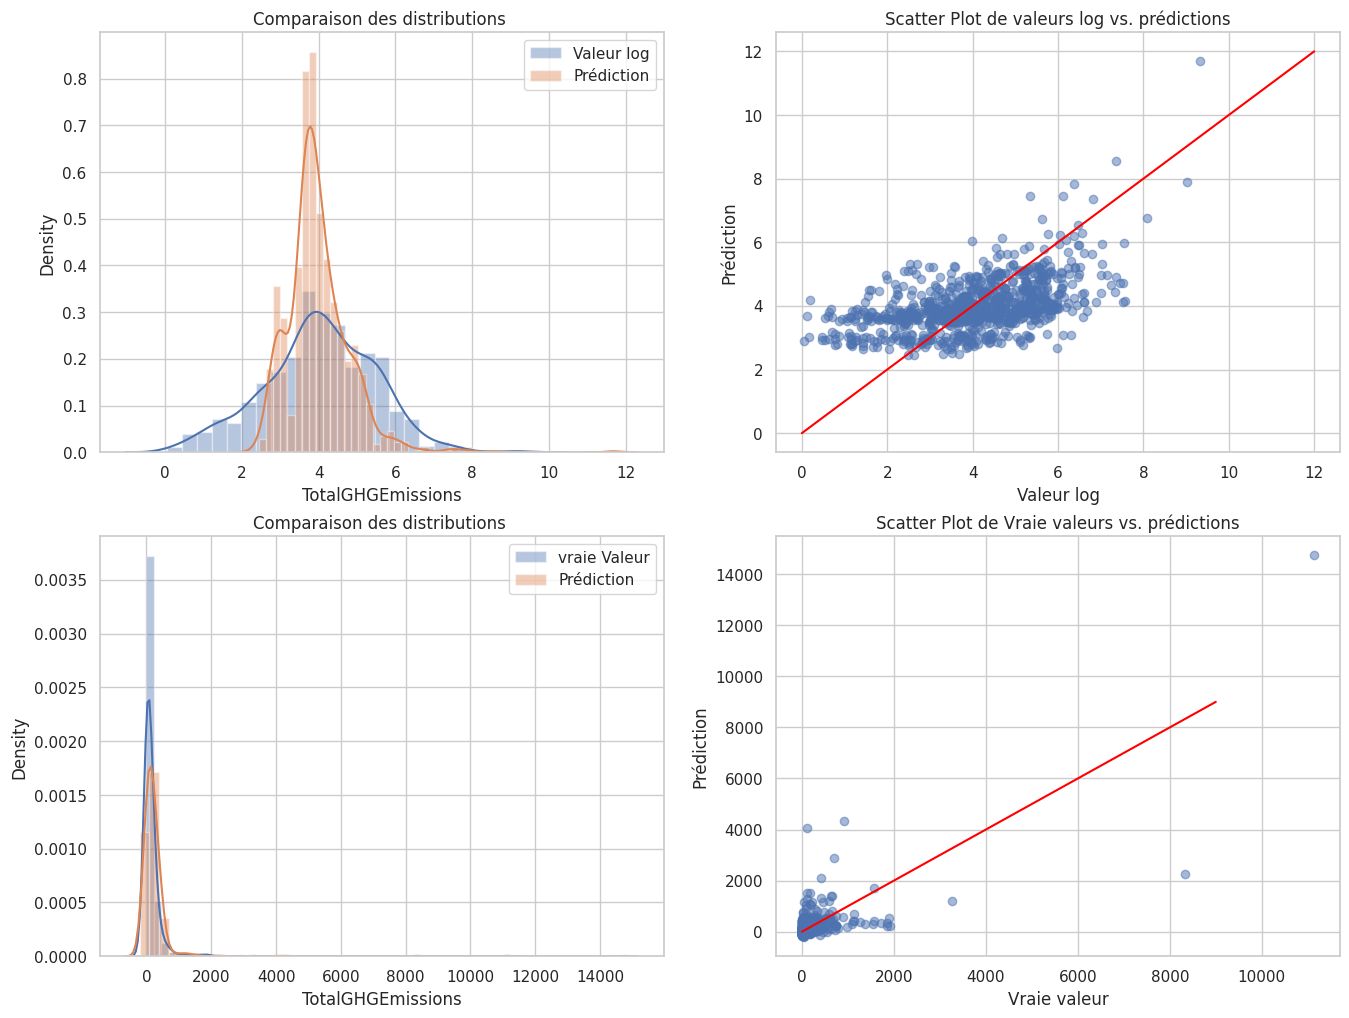

In [50]:
lr_Ridge_score = evaluate_model(data, 'TotalGHGEmissions', LinearRegression(), RidgeCV(alphas=(0.1, 1.0, 10.0)))

### Modèle : LassoCV 
#### LinearRegression : pour la selection de features RFECV

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle :  LassoCV(alphas=(0.1, 1.0, 10.0))
Scores avec la cible transformée en log puis exp


,Training scores,Test scores log,Test scores
RMSE,1.304191,1.250981,5330.094461
MAE,1.014037,0.984576,283.724561
R2,0.242267,0.238219,-108.136666
Median Abs Err,0.834682,0.803203,34.806415
Time,0.065296,0.002410,0.002410


Scores avec cible non transformée


,Training scores,Test scores
R2,0.227402,0.392104
RMSE,694.845897,397.799424
Relative RMSE,3.045893,3.571071
MAE,208.657056,182.526258
Median Abs Err,103.231187,104.320529
Time,0.077775,0.004412


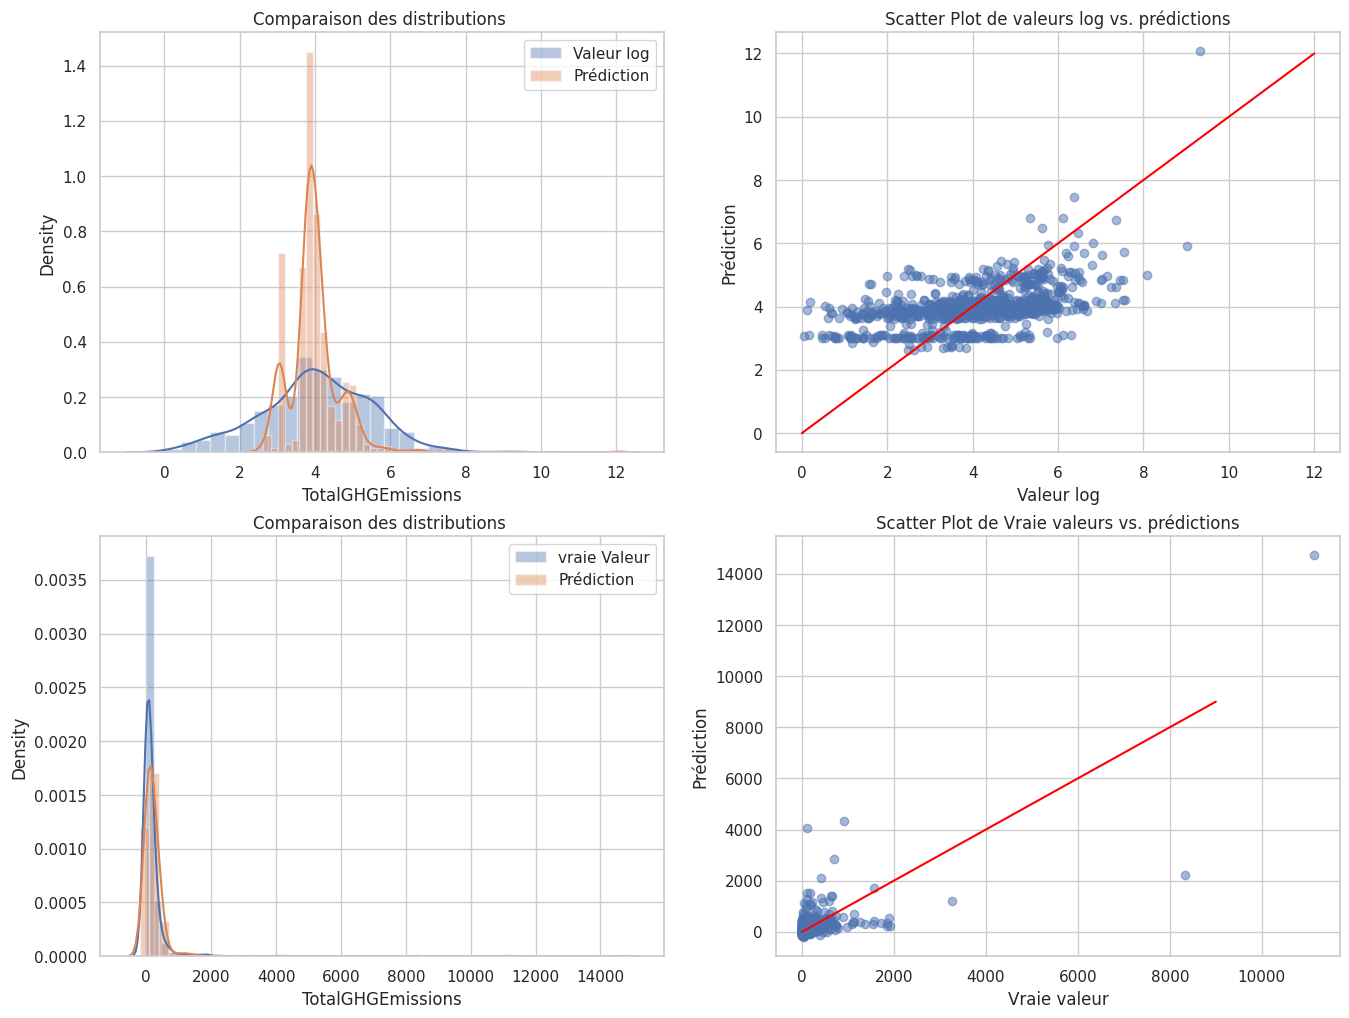

In [51]:
from sklearn.linear_model import LassoCV 
lr_Lasso_score = evaluate_model(data, 'TotalGHGEmissions', LinearRegression(), LassoCV(alphas=(0.1, 1.0, 10.0)))


### Modèle : ElasticNetCV 

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle :  ElasticNetCV(alphas=(0.1, 1.0, 10.0))
Scores avec la cible transformée en log puis exp


,Training scores,Test scores log,Test scores
RMSE,1.292847,1.243761,10166.507074
MAE,1.005453,0.977859,441.121022
R2,0.255391,0.246986,-396.049274
Median Abs Err,0.828319,0.794055,34.285143
Time,0.062623,0.002482,0.002482


Scores avec cible non transformée


,Training scores,Test scores
R2,0.224811,0.394493
RMSE,696.010070,397.017204
Relative RMSE,3.050996,3.564049
MAE,206.699371,179.070598
Median Abs Err,106.310812,109.018475
Time,0.132443,0.001577


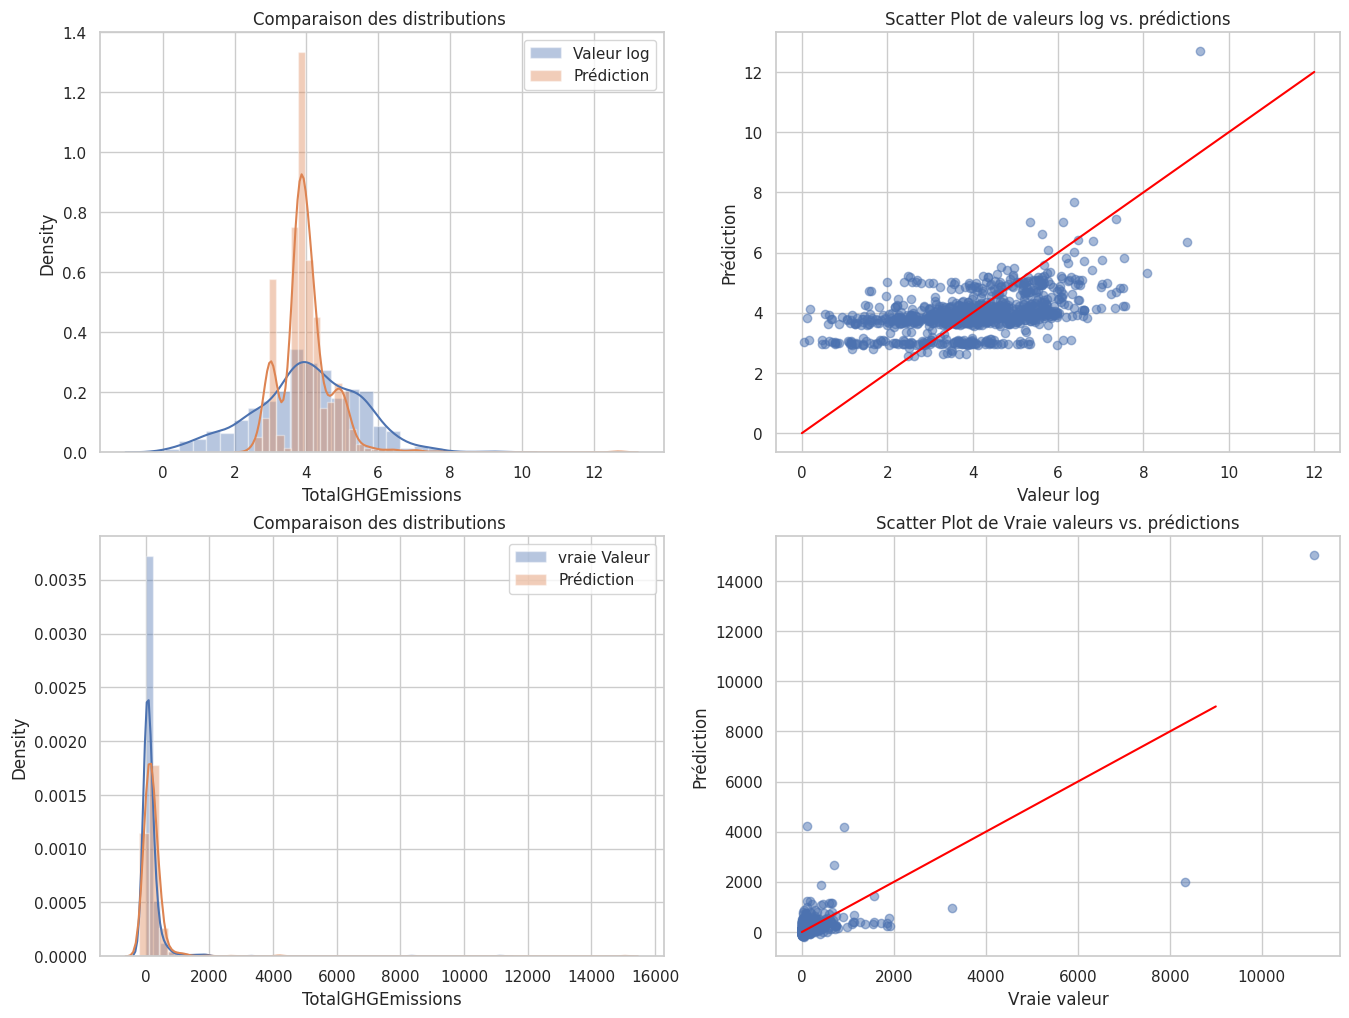

In [52]:
from sklearn.linear_model import ElasticNetCV 

lr_Elas_score = evaluate_model(data, 'TotalGHGEmissions', LinearRegression(), ElasticNetCV(alphas=(0.1, 1.0, 10.0), l1_ratio=0.5))

Nous constatons que les scores des différents modèles linéaires changent en fonction du modèle mais aussi en fonction de la variable cible:
en effet, lorsqu'on utilise la variable cible sans transformation log, les scores sont meilleurs.

Pour la suite, nous allons tester des modèles non linéaires pour prédire la variable cible en vraies grandeurs (sans transformation log)

## II - Modèles non linéaires :

 - Nous créons une nouvelle fonction preprocessing qui utilise le log de la variable cible pour l'encodage et la sélection de features et utilise les vraies valeurs dans le modèle
 - Pour la recherche des hyperparamètres, nous utiliserons la méthode RandomizedSearchCV

In [20]:
# fonction pretraitement

def preprocessing_without_ln(data, target, test_size, random_state, rfe_model):
    # Séparation features et cible
    target = target
    X = data.drop([target], axis=1)
    y = data[target]

    # Transformation de la variable cible
    y_log = y.apply(target_transformation)
    
    # Séparer les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=test_size, random_state=random_state)
    
    # Séparation des variable numériques et catégorielles pour l'encodage
    train_categorical_features = X_train.select_dtypes(include='category')
    test_categorical_features = X_test.select_dtypes(include='category')
    
    train_numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
    test_numerical_features = X_test.select_dtypes(include=['int64', 'float64'])
    
    # Encodage des variables catégorielles
    train_categorical_features, test_categorical_features = encodage(train_categorical_features, test_categorical_features, y_train)
    
    # Fusion des variables catégorielles et numériques
    X_train = pd.merge(train_categorical_features, train_numerical_features, left_index=True, right_index=True)
    X_test = pd.merge(test_categorical_features, test_numerical_features,  left_index=True, right_index=True)

    # Sélection de features avec RFECV
    
    sv = RFECV(rfe_model, step=1, cv=5)
    sv.fit(X_train, y_train)
    selected_columns = [col for col, selected in zip(X_train.columns, sv.support_) if selected]
    X_train = X_train[selected_columns]
    X_test = sv.transform(X_test)
    
    # Accédez aux classements des fonctionnalités
    feature_ranking = sv.ranking_
    # Accédez aux fonctionnalités sélectionnées (True signifie sélectionné)
    selected_features = sv.support_
    
    feature_info = pd.DataFrame({
        'Feature': X.columns, 
        'Ranking': feature_ranking,
        'Selected': selected_features
    })
    print("Données d'entraînement : ", X_train.shape)
    print("Données de test : ", X_test.shape)
    print("Features Sélectionnées par la RFECV :")
    display(feature_info)

    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    return X_train, X_test, y_train, y_test

In [29]:
# fonction pretraitement

def preprocessing_without_ln_2(data, target, test_size, random_state, rfe_model):
    # Séparation features et cible
    target = target
    X = data.drop([target], axis=1)
    y = data[target]

    # Transformation de la variable cible
    # y_log = y.apply(target_transformation)
    
    # Séparer les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Séparation des variable numériques et catégorielles pour l'encodage
    train_categorical_features = X_train.select_dtypes(include='category')
    test_categorical_features = X_test.select_dtypes(include='category')
    
    train_numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
    test_numerical_features = X_test.select_dtypes(include=['int64', 'float64'])
    
    # Encodage des variables catégorielles
    train_categorical_features, test_categorical_features = encodage(train_categorical_features, test_categorical_features, y_train)
    
    # Fusion des variables catégorielles et numériques
    X_train = pd.merge(train_categorical_features, train_numerical_features, left_index=True, right_index=True)
    X_test = pd.merge(test_categorical_features, test_numerical_features,  left_index=True, right_index=True)

    # Sélection de features avec RFECV
    
    sv = RFECV(rfe_model, step=1, cv=5)
    sv.fit(X_train, y_train)
    selected_columns = [col for col, selected in zip(X_train.columns, sv.support_) if selected]
    X_train = X_train[selected_columns]
    X_test = sv.transform(X_test)
    
    # Accédez aux classements des fonctionnalités
    feature_ranking = sv.ranking_
    # Accédez aux fonctionnalités sélectionnées (True signifie sélectionné)
    selected_features = sv.support_
    
    feature_info = pd.DataFrame({
        'Feature': X.columns, 
        'Ranking': feature_ranking,
        'Selected': selected_features
    })
    print("Données d'entraînement : ", X_train.shape)
    print("Données de test : ", X_test.shape)
    print("Features Sélectionnées par la RFECV :")
    display(feature_info)

    # y_train = np.exp(y_train)
    # y_test = np.exp(y_test)
    return X_train, X_test, y_train, y_test

In [21]:
def graph_show(y_test,y_pred):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.distplot(y_test, ax = axes[0], label='vraie Valeur' )
    sns.distplot(y_pred, ax = axes[0], label='Prédiction')
    axes[0].set_title('Comparaison des distributions ')
    axes[0].legend()
    
    axes[1].scatter(y_test, y_pred, alpha=0.5)
    axes[1].plot([0, 9e3],[0, 9e3], color = 'red', linestyle = '-', linewidth = 1.5)
    axes[1].set_xlabel("Vraie valeur")
    axes[1].set_ylabel("Prédiction")
    axes[1].set_title("Scatter Plot de Vraie valeurs vs. prédictions")

    plt.show()

In [30]:
from sklearn.model_selection import GridSearchCV
import shap

def evaluate_model_grid_CV_2(data, target, test_size, random_state, rfe_model, prediction_model, param_grid):  
    warnings.filterwarnings("ignore")
    
    X_train, X_test, y_train, y_test = preprocessing_without_ln_2(data, target, test_size, random_state, rfe_model)
    scaler = RobustScaler()
    # Le pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', prediction_model)
    ])
    # Temps recherche hyperparapètres
    start_grid = time.time()
    # Recherche des meilleurs hyperparamètres en utilisant le pipeline
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_median_absolute_error']
    grid_search = GridSearchCV(pipeline,
                               param_grid, 
                               cv=5, 
                               scoring=scoring,
                               refit="neg_mean_squared_error"
                              )

    grid_search.fit(X_train, y_train)
    end_grid = time.time()
    gridsearch_time = end_grid - start_grid

    cv_results = grid_search.cv_results_
    mean_mae = (-cv_results['mean_test_neg_mean_absolute_error']).mean()
    mean_rmse = np.sqrt((-cv_results['mean_test_neg_mean_squared_error']).mean())
    mean_relative_rmse = (mean_rmse/(y_train.max()-y_train.min()))*100
    mean_r2 = cv_results['mean_test_r2'].mean()
    mean_med_abs_err = -cv_results['mean_test_neg_median_absolute_error'].mean()

     # # Obtenez les meilleurs hyperparamètres
    best_params = grid_search.best_params_
    
    
    # Entraînez le modèle avec les meilleurs hyperparamètres
    best_model = grid_search.best_estimator_
    
    # Prédictions avec le modèle optimisé
    # Temps de prédiction 
    start_pred = time.time()
    y_pred = best_model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred

    # Mesures des performances 
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_err = median_absolute_error(y_test, y_pred)
    relative_rmse = (rmse/(y_test.max()-y_test.min()))*100

    print(f'Modèle : {prediction_model}')
    print(f'Meilleurs hyperparamètres: {best_params}')
    
    score_info = {"Gridsearch scores": [mean_r2, mean_rmse, mean_relative_rmse, mean_mae, mean_med_abs_err, gridsearch_time],
                  "Test scores ": [r2, rmse, relative_rmse, mae, med_abs_err, prediction_time]
                 }
    df_score_info = pd.DataFrame(score_info,
                          index = ['R2', 'RMSE', 'Relative RMSE', 'MAE', 'Median Abs Err', 'Time'])

    display(df_score_info)
    
    graph_show(y_test,y_pred)

    
    return df_score_info, X_train, X_test, y_train, y_test


## II.1 - Modèle KernelRidge

- Pour visualiser l'impact des variable sur le modèle, nous utilisons la librairie Shap.
 - En raison de problème de mémoire, l'analyse sera resteinte sur 100 premières prédictions.

In [55]:
from sklearn.kernel_ridge import KernelRidge

Données d'entraînement :  (3758, 13)
Données de test :  (940, 13)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,2,False
4,CouncilDistrictCode,1,True
5,BuildingAge,3,False
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : KernelRidge()
Meilleurs hyperparamètres: {'model__alpha': 0.01, 'model__gamma': 0.1, 'model__kernel': 'laplacian'}


,Gridsearch scores,Test scores
R2,0.153098,0.281673
RMSE,584.080734,917.721230
Relative RMSE,3.543941,4.022882
MAE,123.271974,100.517679
Median Abs Err,31.228486,18.720870
Time,1700.311704,0.164166


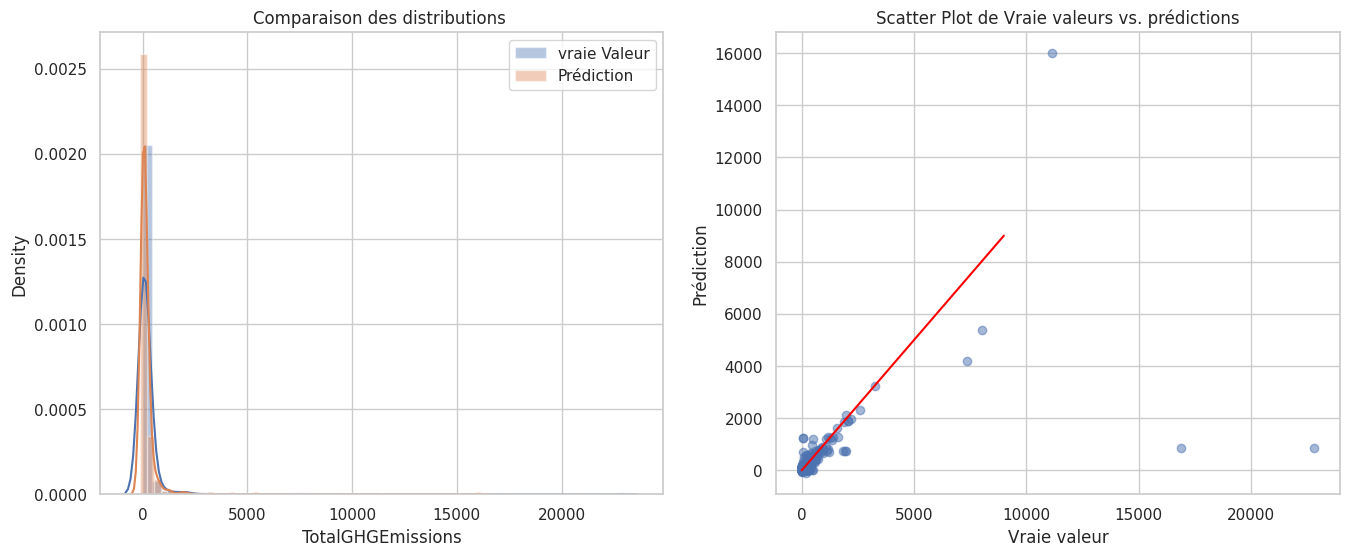

In [25]:
rfe_model = LinearRegression()
prediction_model = KernelRidge()
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0],  # Différentes valeurs d'alpha à tester
    'model__kernel': ['laplacian', 'polynomial', 'rbf'],  # Différents types de noyaux à tester
    'model__gamma': [0.1, 0.5, 1.0]  # Hyperparamètre spécifique au noyau 
}
test_size = 0.2
random_state = 12
lr_kern_score_2, X_train_22, X_test_22, y_train_22, y_test_22 = evaluate_model_grid_CV(data, 
                                                                                      'TotalGHGEmissions',
                                                                                        test_size, 
                                                                                        random_state, 
                                                                                        rfe_model,
                                                                                        prediction_model,
                                                                                        param_grid)

- Ici nous avons utilisé la régression linéaire pour la sélection de variable. La RFE a retenu 13 variables.
- Avec cette méthode de sélection et le modèle kernelRidge(alpha=0.01, gamma=0.1, kernel='laplacian'), nous avons obtenu un score de détermination r2_score = 0.28.


#### Fonction avec Random Search CV :

In [36]:
from sklearn.model_selection import RandomizedSearchCV
import shap

def evaluate_model_random_CV(data, target, test_size, random_state, rfe_model, prediction_model, param_grid):
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = preprocessing_without_ln_2(data, target, test_size, random_state, rfe_model)
    scaler = RobustScaler()
    # Le pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', prediction_model)
    ])
    
    # Temps recherche hyperparapètres
    start_grid = time.time()
    # Recherche des meilleurs hyperparamètres en utilisant le pipeline
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_median_absolute_error']
    grid_search = RandomizedSearchCV(pipeline,
                                     param_grid, 
                                     cv=5,
                                     n_iter=10,
                                     scoring=scoring,
                                     refit="neg_mean_squared_error",
                                     random_state=42
                                    )
 
    grid_search.fit(X_train, y_train)
    end_grid = time.time()
    gridsearch_time = end_grid - start_grid

    cv_results = grid_search.cv_results_
    train_mae = (-cv_results['mean_test_neg_mean_absolute_error']).mean()
    train_rmse = np.sqrt((-cv_results['mean_test_neg_mean_squared_error']).mean())
    train_relative_rmse = (train_rmse/(y_train.max()-y_train.min()))*100
    train_r2 = cv_results['mean_test_r2'].mean()
    train_med_abs_err = -cv_results['mean_test_neg_median_absolute_error'].mean()
    
    # Obtenez les meilleurs hyperparamètres
    best_params = grid_search.best_params_
    
    # Entraînez le modèle avec les meilleurs hyperparamètres
    best_model = grid_search.best_estimator_


    # train_rmse = math.sqrt(mean_squared_error(y_train, best_model.predict(X_train)))
    # train_mae = mean_absolute_error(y_train, best_model.predict(X_train))
    # train_r2 = r2_score(y_train, best_model.predict(X_train))
    # train_med_abs_err = median_absolute_error(y_train, best_model.predict(X_train))
    # train_relative_rmse = (train_rmse/(y_train.max()-y_train.min()))*100
    
    # Prédictions avec le modèle optimisé
    # Temps de prédiction
    start_pred = time.time()
    y_pred = best_model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred

    # Mesures des performances - cible
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_err = median_absolute_error(y_test, y_pred)
    relative_rmse = (rmse/(y_test.max()-y_test.min()))*100

    print(f'Modèle : {prediction_model}')
    print(f'Meilleurs hyperparamètres: {best_params}')
    

    score_info = {"RandomizedCV scores" : [train_r2, train_rmse, train_relative_rmse, train_mae, train_med_abs_err, gridsearch_time],
                  "Test scores": [r2, rmse, relative_rmse, mae, med_abs_err, prediction_time]
                 }
    df_score_info = pd.DataFrame(score_info,
                          index = ['R2', 'RMSE', 'Relative RMSE', 'MAE', 'Median Abs Err', 'Time'])
    display(df_score_info)
    graph_show(y_test,y_pred)
    
    return df_score_info, X_train, X_test, y_train, y_test

## II.2 - Modèle SVR (Support Vector Regression)

Données d'entraînement :  (3758, 14)
Données de test :  (940, 14)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : SVR()
Meilleurs hyperparamètres: {'model__kernel': 'linear', 'model__gamma': 'auto', 'model__epsilon': 0.1, 'model__C': 1.0}


,RandomizedCV scores,Test scores
R2,0.088651,0.637580
RMSE,756.923014,307.153654
Relative RMSE,3.318011,2.757338
MAE,152.953721,106.081357
Median Abs Err,33.305639,34.012301
Time,44.453799,0.089013


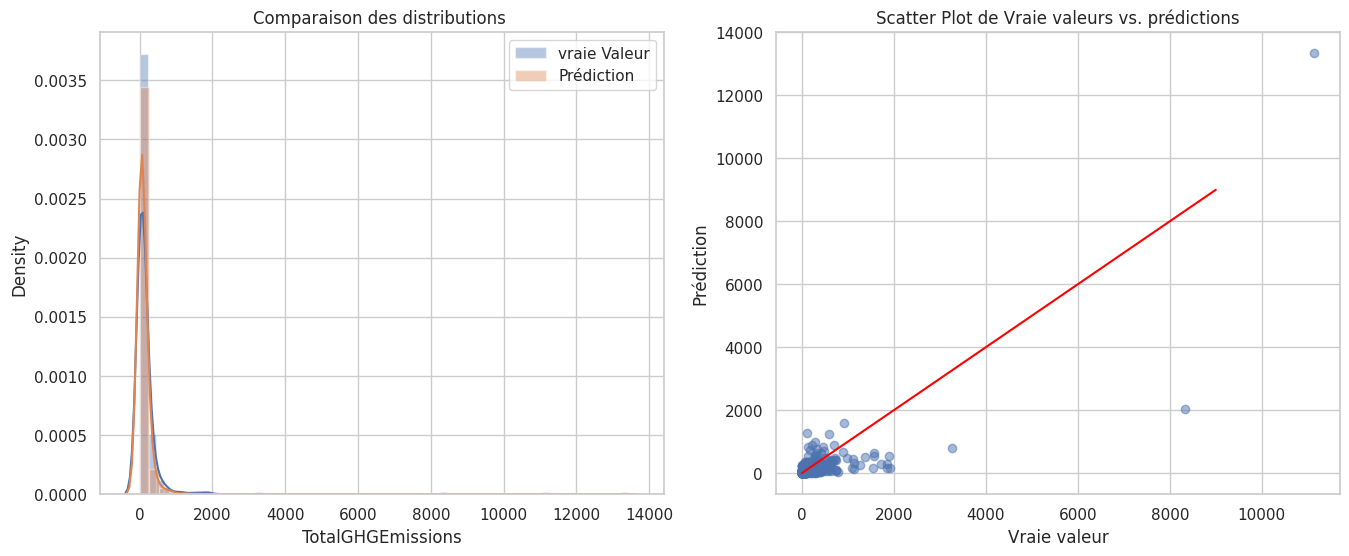

In [61]:
from sklearn.svm import SVR

rfe_model = LinearRegression()
prediction_model = SVR()
param_grid = {
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # Différents types de noyaux à tester
    'model__gamma': ['scale', 'auto'],
    'model__C': [0.1, 1.0, 10.0],
    'model__epsilon': [0.1, 0.2, 0.5]
}
test_size = 0.2
random_state = 0
lr_SVR_score, X_train_3, X_test_3, y_train_3, y_test_3 = evaluate_model_random_CV(data, 
                                                                                   'TotalGHGEmissions',
                                                                                    test_size,
                                                                                    random_state,
                                                                                   rfe_model, 
                                                                                   prediction_model,
                                                                                   param_grid)

- Le modèle SVR est moins perfomant que les modèles linéaires, le r2_score de la validation croisée est trop bas comparé au score de test.

 - Le temps d'entrainement plus court avec RandomizedSearchCV
   
Passons aux modèles ensemblistes


## III - Modèles ensemblistes :

### III. 1 - Random Forrest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor

Données d'entraînement :  (3758, 14)
Données de test :  (940, 14)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : RandomForestRegressor()
Meilleurs hyperparamètres: {'model__n_estimators': 100, 'model__max_depth': 20}


,RandomizedCV scores,Test scores
R2,0.809725,0.650418
RMSE,347.971839,301.664335
Relative RMSE,1.525353,2.708060
MAE,74.589240,68.969051
Median Abs Err,20.446254,16.697737
Time,729.806286,0.024068


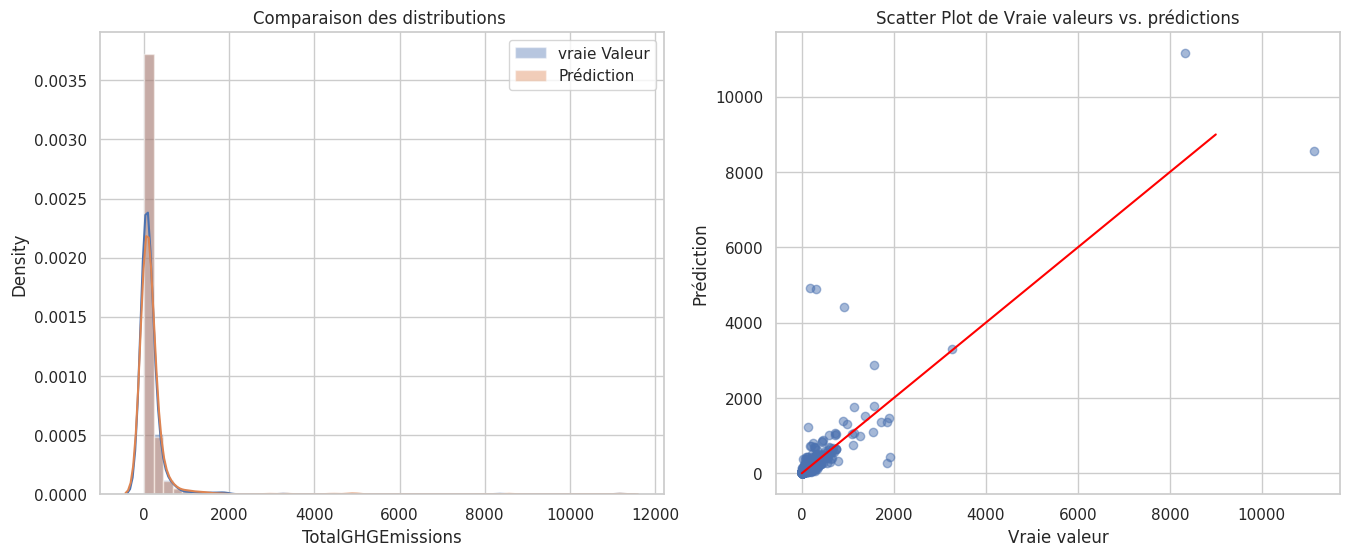

In [38]:
rfe_model = LinearRegression()
prediction_model = RandomForestRegressor()
param_grid = {'model__max_depth': [10, 20, 50, 70, 90, 100, None],
              'model__n_estimators': [100, 500, 1000]
             }
test_size = 0.2
random_state = 0
lr_RFR_score, X_train_4, X_test_4, y_train_4, y_test_4 = evaluate_model_random_CV(data, 
                                                                                   'TotalGHGEmissions', 
                                                                                    test_size, 
                                                                                    random_state,
                                                                                    rfe_model, 
                                                                                   prediction_model, 
                                                                                   param_grid)

In [39]:
lr_RFR_score

,RandomizedCV scores,Test scores
R2,0.809725,0.650418
RMSE,347.971839,301.664335
Relative RMSE,1.525353,2.708060
MAE,74.589240,68.969051
Median Abs Err,20.446254,16.697737
Time,729.806286,0.024068


 - Nous avons utliser le modèle régression linéaire pour la selection des features, la RFE a retenu 12 variable parmi les 17 présentes.
 - Le modèle RandomForest a un score de détermination aussi élevé que le modèle KernelRidge (r2_score = 0.81)
 - Le RMSE et RMSE relatif est légèrement supérieur à ceux obtenus par KernelRidge mais restent meilleurs que ceux obtenus avec les modèles linéaires et SVR.

Visualisons les variables qui présentent un impact sur le modèle :

In [41]:
model_4 = RandomForestRegressor(n_estimators=100, max_depth=10) 

model_4.fit(X_train_4, y_train_4)

# Créer un objet explainer SHAP
explainer_4 = shap.Explainer(model_4.predict, X_train_4, feature_names=X_train_4.columns)

# Obtenir des explications SHAP 
shap_values_4 = explainer_4(X_test_4)

ExactExplainer explainer: 941it [04:50,  3.15it/s]                              


In [42]:
shap.initjs()

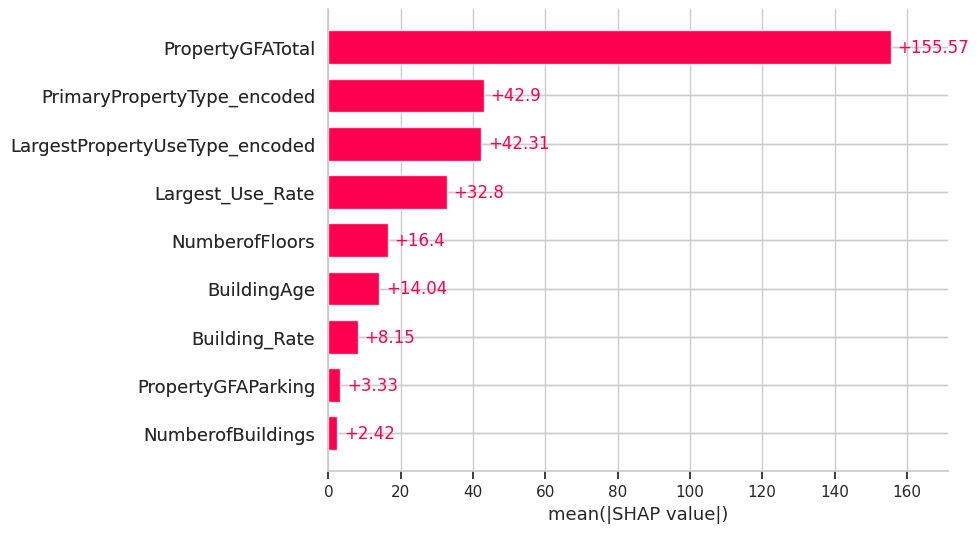

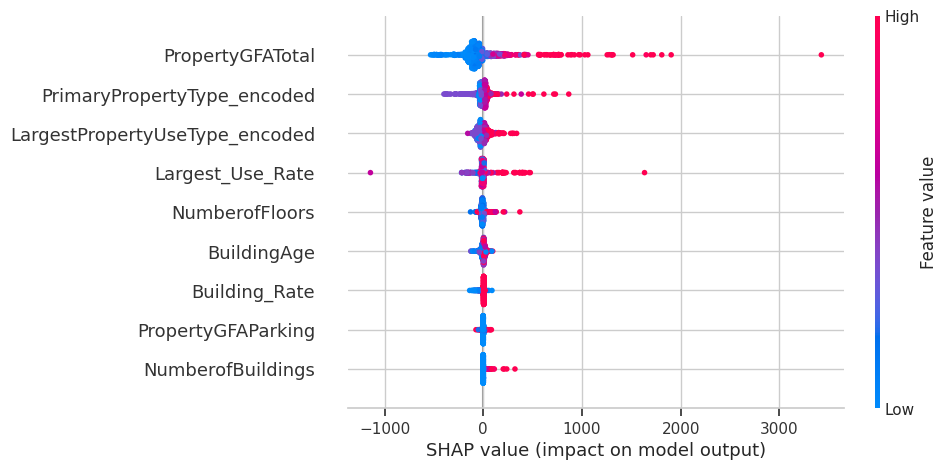

In [43]:
shap.plots.bar(shap_values_4)
shap.plots.beeswarm(shap_values_4)

##### Interprétation :
 - La variable PropertyGFATotal semble avoir un plus grand impact sur les prédiction avec le modèle RandomForest
 - Nous constatons que la Longitude a un plus grand impact que la Latitude, ce qui peut être explique par la frome de la ville de Seattle dont la longueur est plus importante que la largeur.

### 2. Modèle XGBoost

In [27]:
from xgboost import XGBRegressor

Données d'entraînement :  (3758, 14)
Données de test :  (940, 14)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Meilleurs hyperparamètres: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 300}


,Gridsearch scores,Test scores
R2,0.797959,0.780268
RMSE,350.318134,239.164153
Relative RMSE,1.535638,2.146992
MAE,90.723312,64.843141
Median Abs Err,39.788963,21.126569
Time,26.165442,0.002236


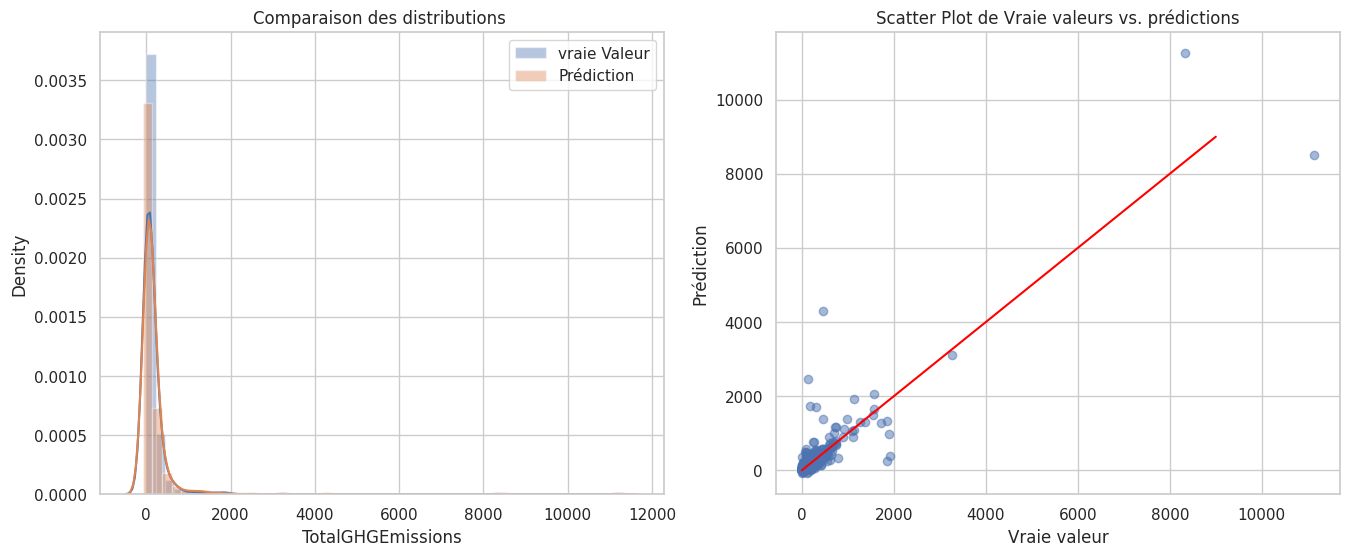

In [34]:
rfe_model = LinearRegression()
prediction_model = XGBRegressor()
param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5]
}
test_size = 0.2
random_state = 0
lr_xgb_score, X_train_6, X_test_6, y_train_6, y_test_6 = evaluate_model_grid_CV_2(data, 
                                                                               'TotalGHGEmissions',
                                                                                test_size, 
                                                                                random_state,
                                                                               rfe_model,
                                                                               prediction_model, 
                                                                               param_grid)

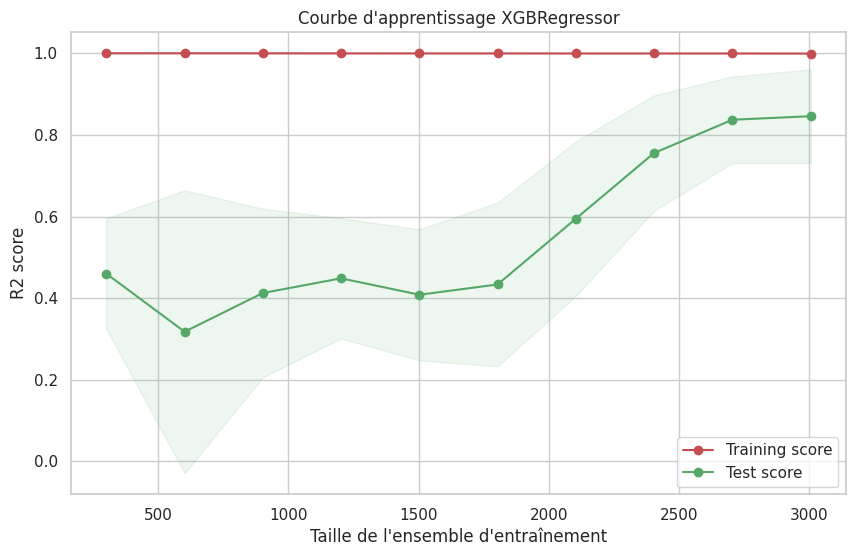

In [62]:
from sklearn.model_selection import learning_curve
model_xgb = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.2)

train_sizes, train_scores, test_scores = learning_curve(model_xgb,
                                                        X_train_6,
                                                        y_train_6,
                                                        cv=5,
                                                        scoring='r2',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Courbe d'apprentissage XGBRegressor")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("R2 score")
plt.grid(True)


plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score ")

plt.legend(loc="lower right")
plt.show()

 - Le modèle XGBoost a de meilleurs performances et un temps plus court que le modèle RandomForest ou KernelRidge.
   
Passons aux features importances:

#### Features importances : 

##### a- Globale :

In [73]:
import shap
# model_6 = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.3)

model_xgb.fit(X_train_6, y_train_6)

# Créer un objet explainer SHAP
explainer_6 = shap.Explainer(model_xgb.predict, X_train_6, feature_names=X_train_6.columns)

# Obtenir des explications SHAP des prédictions
shap_values_6 = explainer_6(X_test_6)

PermutationExplainer explainer: 941it [01:23,  9.86it/s]                        


In [74]:
shap.initjs()

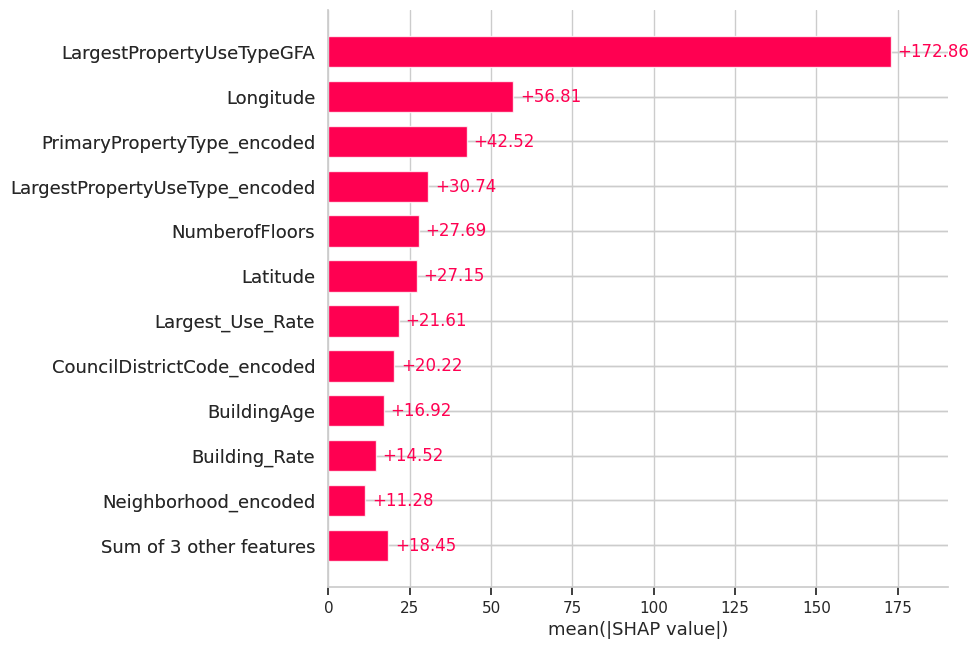

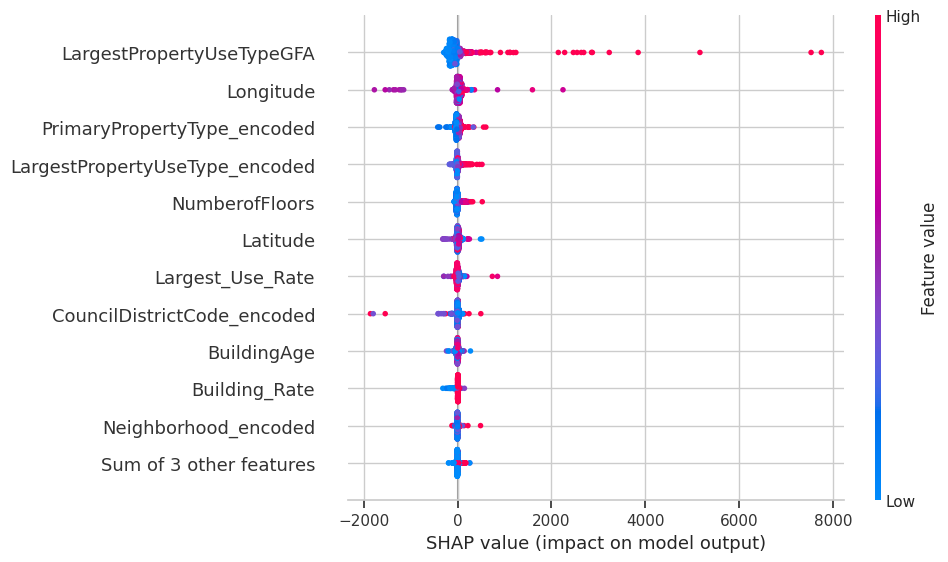

In [75]:
shap.plots.bar(shap_values_6, max_display=12)
shap.plots.beeswarm(shap_values_6, max_display=12)

##### Interprétation :
 - La variable PropertyGFABuilding(s) semble avoir le plus grand impact sur le modèle XGboost.
 - Comme avec le modèle RandomForest, l'impact de la longitude est plus important que la latitude.


#### b- Locale :

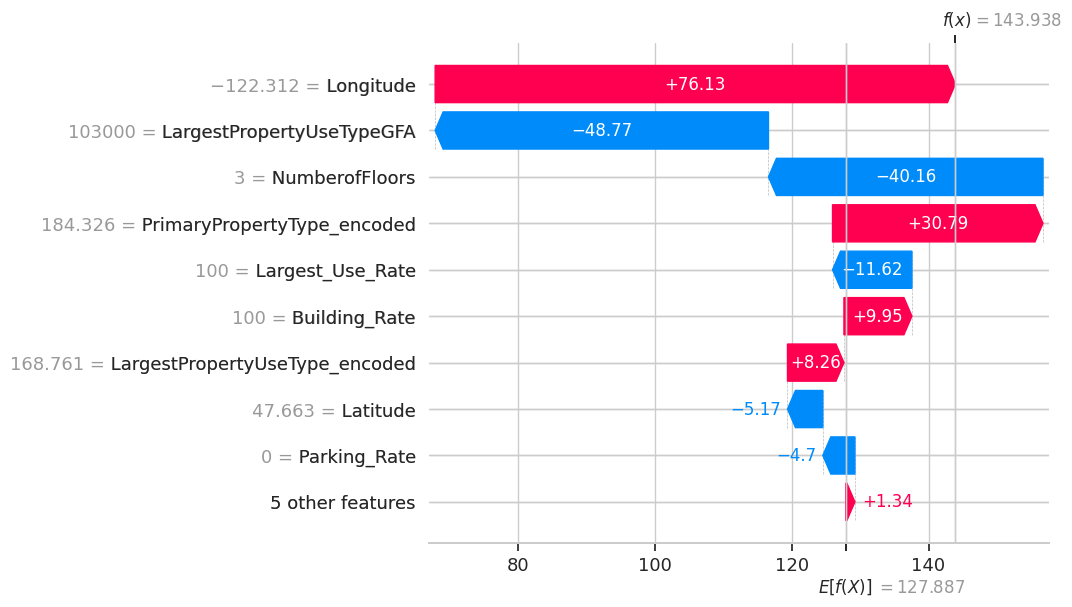

In [76]:
shap.plots.waterfall(shap_values_6[350])
shap.plots.force(shap_values_6[350])

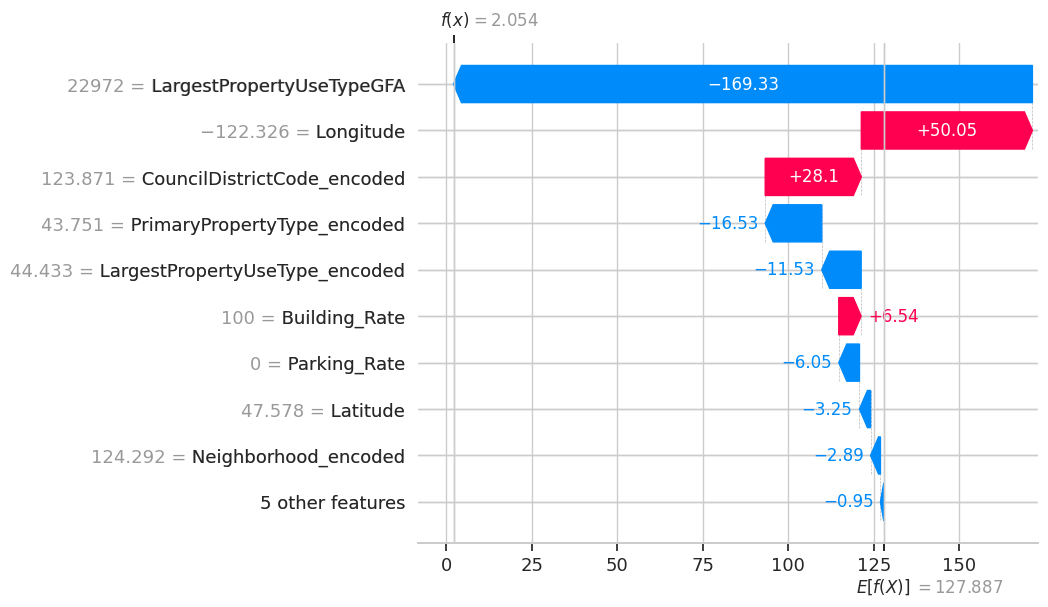

In [78]:
shap.plots.waterfall(shap_values_6[900])
shap.plots.force(shap_values_6[900])

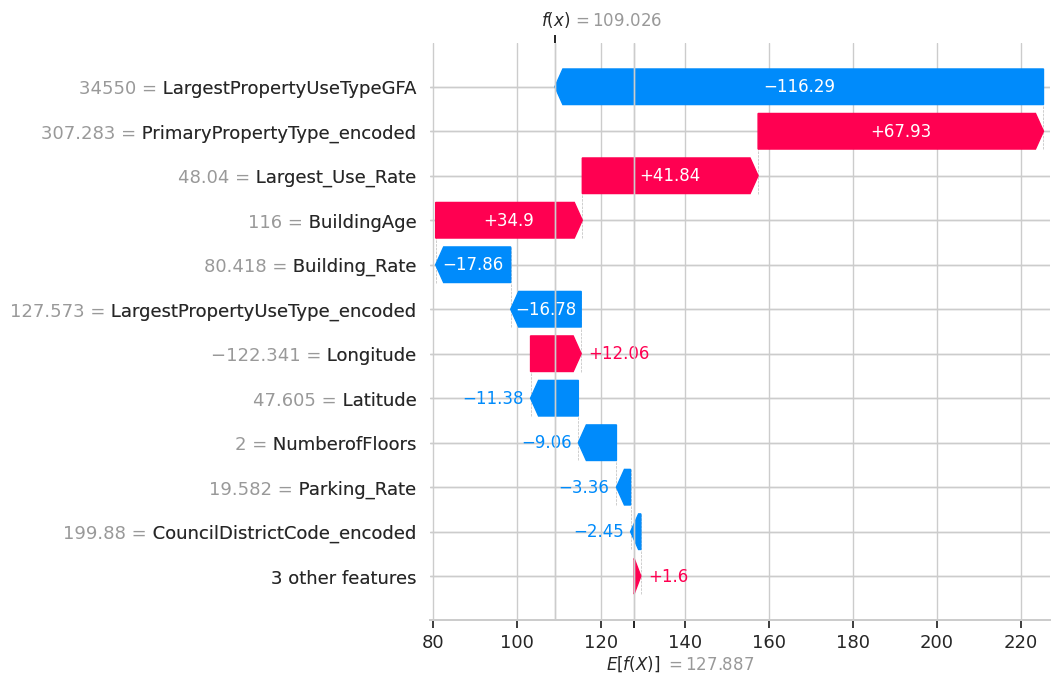

In [77]:
shap.plots.waterfall(shap_values_6[250], max_display=12)
shap.plots.force(shap_values_6[250])

## IV- Comparaison des modèles :

In [63]:
lr = list(lr_score['Test scores'])
lr.append(lr_score.loc['Time'][0])

ridge = list(lr_Ridge_score['Test scores'])
ridge.append(lr_Ridge_score.loc['Time'][0])

lasso = list(lr_Lasso_score['Test scores'])
lasso.append(lr_Lasso_score.loc['Time'][0])

ElasNet = list(lr_Elas_score['Test scores'])
ElasNet.append(lr_Elas_score.loc['Time'][0])

kernelRdg = list(lr_kern_score_2['Test scores '])
kernelRdg.append(lr_kern_score_2.loc['Time'][0])

SVR = list(lr_SVR_score['Test scores'])
SVR.append(lr_SVR_score.loc['Time'][0])

RFR = list(lr_RFR_score['Test scores'])
RFR.append(lr_RFR_score.loc['Time'][0])

Xgb = list(lr_xgb_score['Test scores '])
Xgb.append(lr_xgb_score.loc['Time'][0])

In [64]:
metriques = ['R2', 'RMSE', 'Relative RMSE', 'MAE', 'Median Abs Err', 'Prediction time', 'Training time']

df = {
    'lr': lr,
    'Ridge': ridge,
    'Lasso': lasso,
    'ElastNet': ElasNet,
    'KernelRdg': kernelRdg,
    'SVR': SVR,
    'RFR': RFR,
    'XGBoost': Xgb
}

# Créez un DataFrame à partir du dictionnaire
df_score_2 = pd.DataFrame(df, index=metriques)
df_score_2

,lr,Ridge,Lasso,ElastNet,KernelRdg,SVR,RFR,XGBoost
R2,0.386957,0.390059,0.392104,0.394493,0.281673,0.637580,0.650418,0.780268
RMSE,399.479879,398.468114,397.799424,397.017204,917.721230,307.153654,301.664335,239.164153
Relative RMSE,3.586156,3.577074,3.571071,3.564049,4.022882,2.757338,2.708060,2.146992
MAE,183.602202,182.929682,182.526258,179.070598,100.517679,106.081357,68.969051,64.843141
Median Abs Err,104.812591,105.117241,104.320529,109.018475,18.720870,34.012301,16.697737,21.126569
Prediction time,0.000947,0.006484,0.004412,0.001577,0.164166,0.089013,0.024068,0.002236
Training time,0.034088,0.080240,0.077775,0.132443,1700.311704,44.453799,729.806286,26.165442


In [65]:
df_score_2.to_csv('df_score_emission.csv')

Pour la prédiction des émissions de CO2, nous avons retenu le modèle XGBoost(n_estimators=200, max_depth=5, learning_rate=0.3), ayant les meilleurs scores et un temps de prédiction plus court que le modèle KernelRidge ou RandomForest.

Dans le prochain notebook, nous allons étudier la pertinence de la varible EnergyStarScore avec le modèle sélectionné pour la prédiction des émissions de CO2.

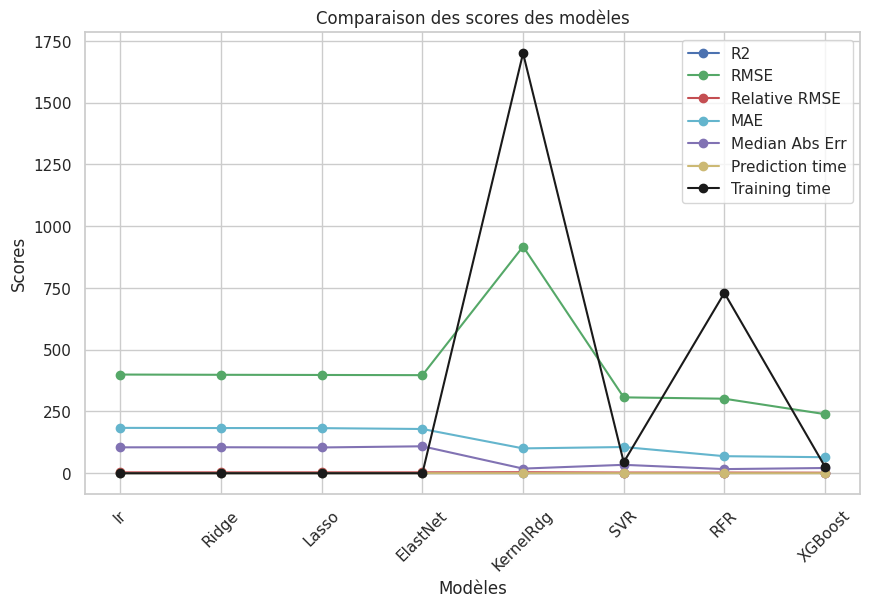

In [66]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
# Tracé des scores
plt.figure(figsize=(10, 6))  

for score, color in zip(metriques, colors):
    plt.plot(df_score_2.columns, df_score_2.loc[score], label=score, marker='o', color=color)

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Comparaison des scores des modèles')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(True)

plt.show()


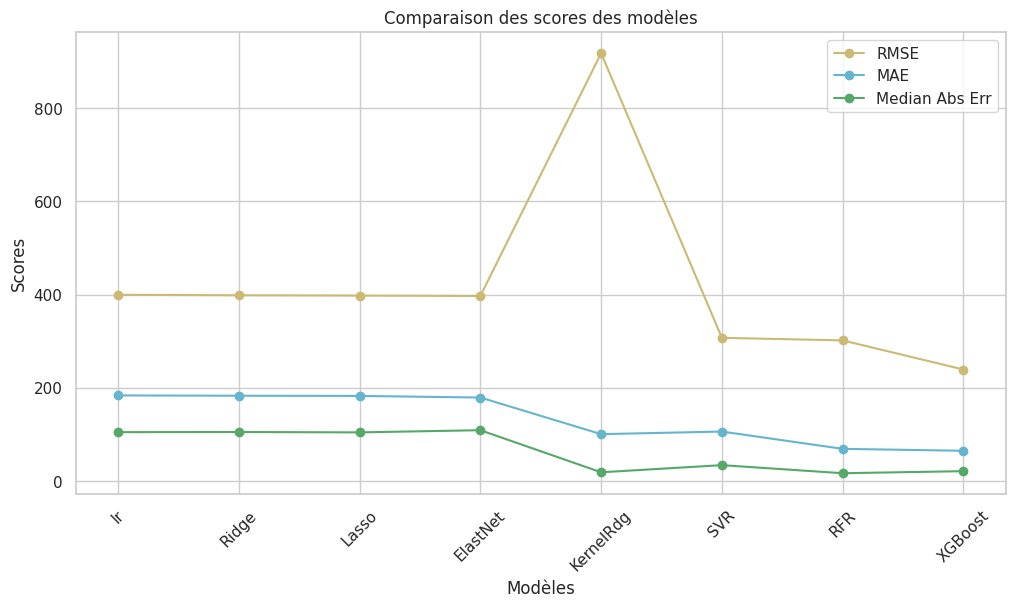

In [67]:
colors = ['y', 'c', 'g']
metrics_to_plot = ['RMSE', 'MAE', 'Median Abs Err']
# Tracé des scores
plt.figure(figsize=(12, 6))  
for score, color in zip(metrics_to_plot, colors):
    plt.plot(df_score_2.columns, df_score_2.loc[score], label=score, marker='o', color=color)

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Comparaison des scores des modèles')
plt.legend()
plt.xticks(rotation=45)  
plt.grid(True)

plt.show()

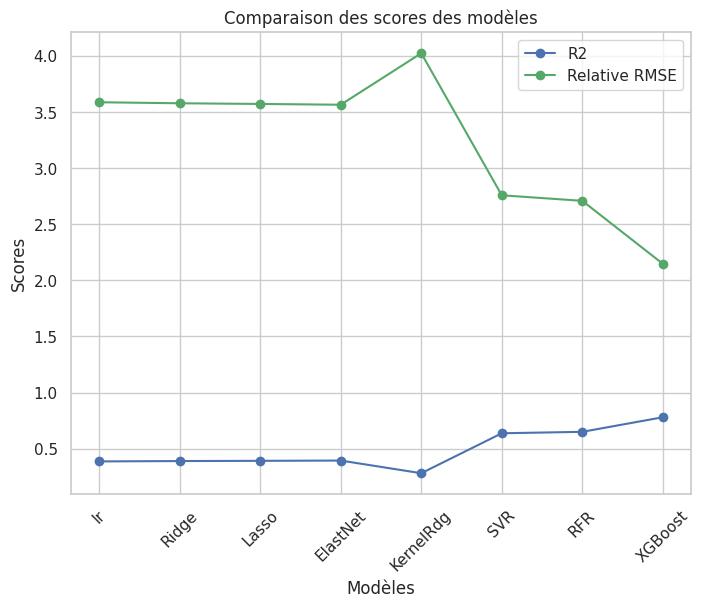

In [68]:
colors = ['b', 'g']
metrics_to_plot = ['R2', 'Relative RMSE']
# Tracé des scores
plt.figure(figsize=(8, 6)) 

for score, color in zip(metrics_to_plot, colors):
    plt.plot(df_score_2.columns, df_score_2.loc[score], label=score, marker='o', color=color)

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Comparaison des scores des modèles')
plt.legend()
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()

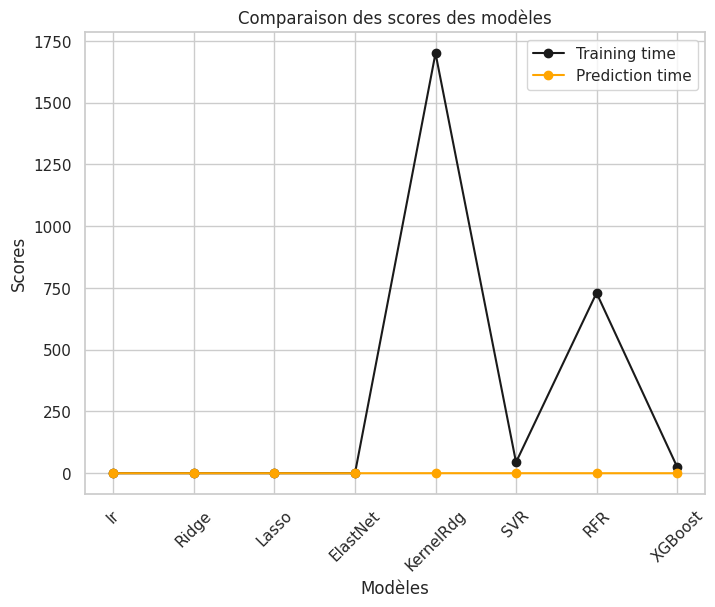

In [69]:
colors = ['k', 'orange']
metrics_to_plot = ['Training time', 'Prediction time']
# Tracé des scores
plt.figure(figsize=(8, 6)) 

for score, color in zip(metrics_to_plot, colors):
    plt.plot(df_score_2.columns, df_score_2.loc[score], label=score, marker='o', color=color)

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Comparaison des scores des modèles')
plt.legend()
plt.xticks(rotation=45)  
plt.grid(True)

plt.show()

Le modèle retenu pour la prédiction des émissions de CO2 est : XGBoost(n_estimators=300, max_depth=5, learning_rate=0.2)

In [71]:
print("Modèle final : XGBRegressor")
print("Meilleurs paramètres : n_estimators=300, max_depth=5, learning_rate=0.2")
lr_xgb_score

Modèle final : XGBRegressor
Meilleurs paramètres : n_estimators=300, max_depth=5, learning_rate=0.2


,Gridsearch scores,Test scores
R2,0.797959,0.780268
RMSE,350.318134,239.164153
Relative RMSE,1.535638,2.146992
MAE,90.723312,64.843141
Median Abs Err,39.788963,21.126569
Time,26.165442,0.002236
